In [1]:
"""
    Using an industry model, check for hallucinations between generated items and item responses.
    Basically, we need a measure of faithfullness that the responder agent actually answered the generator agent
"""
import pandas as pd
import os
from transformers import AutoModelForSequenceClassification
from os.path import join
item_gen_path = "/home/aml7990/Code/creativity-item-generation/outputs/CPS/"

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# taken from the analyze outputs script
# TODO: probably helpful enough to make a function as a top level util.py
use_rescored = False
dirs = [
    d
    for d in os.listdir(item_gen_path)
    if os.path.isdir(os.path.join(item_gen_path, d))
]
all_items_round_0 = []
all_item_responses_round_0 = []
all_item_responses_round_4 = []
all_items_round_4 = []
for d in dirs:
    # skip over runs that are still processing:
    print(d)
    files = os.listdir(join(item_gen_path, d))
    if use_rescored:
        if "config.json" not in files or "items.json" not in files or "item_responses_round_0_rescored.json" not in files or "item_responses_round_4_rescored.json" not in files:
            continue
    else:
        if "config.json" not in files or "items.json" not in files or "item_responses_round_0.json" not in files or "item_responses_round_4.json" not in files:
            continue
    items = pd.read_json(join(item_gen_path, d, "items.json"))
    config = pd.read_json(join(item_gen_path, d, "config.json"), typ='series')
    if use_rescored:
        item_responses_round_0 = pd.read_json(join(item_gen_path, d, "item_responses_round_0_rescored.json"))
        item_responses_round_4 = pd.read_json(join(item_gen_path, d, "item_responses_round_4_rescored.json"))
    else:
        item_responses_round_0 = pd.read_json(join(item_gen_path, d, "item_responses_round_0.json"))
        item_responses_round_4 = pd.read_json(join(item_gen_path, d, "item_responses_round_4.json"))
    if len(items) == 0:
        continue

    items_round_0 = items[
        ["creative_scenario_round_0", "word_list", "item_gen_model_name"]
    ]
    items_round_4 = items[
        ["creative_scenario_round_4", "word_list", "item_gen_model_name"]
    ]
    items_round_0["originality_mean"] = item_responses_round_0["originality_round_0"].mean()
    items_round_4["originality_mean"] = item_responses_round_4["originality_round_4"].mean()
    items_round_0["itemResponsePrompt"] = config["itemResponseGenPromptIdx"]
    items_round_4["itemResponsePrompt"] = config["itemResponseGenPromptIdx"]
    config = pd.read_json(join(item_gen_path, d, "config.json"), orient="index").T
    combined_round_0 = items_round_0.merge(
        config, how="outer", left_on="item_gen_model_name", right_on="itemGenModelName"
    )
    combined_round_4 = items_round_4.merge(
        config, how="outer", left_on="item_gen_model_name", right_on="itemGenModelName"
    )
    if "/" in combined_round_0["itemGenModelName"].iloc[0]:
        combined_round_0["itemGenModelName"] = combined_round_0["itemGenModelName"].iloc[0].split("/")[1]
    if "/" in combined_round_4["itemGenModelName"].iloc[0]:
        combined_round_4["itemGenModelName"] = combined_round_4["itemGenModelName"].iloc[0].split("/")[1]
    all_items_round_0.append(combined_round_0)
    all_items_round_4.append(combined_round_4)
    all_item_responses_round_0.append(item_responses_round_0)
    all_item_responses_round_4.append(item_responses_round_4)

all_items_round_0 = pd.concat(all_items_round_0).reset_index(drop=True)
all_items_round_4 = pd.concat(all_items_round_4).reset_index(drop=True)
all_item_responses_round_0 = pd.concat(all_item_responses_round_0).reset_index(drop=True)
all_item_responses_round_4 = pd.concat(all_item_responses_round_4).reset_index(drop=True)

# Detection using an off the shelf hallucination model

In [3]:
all_item_responses_round_0 = all_item_responses_round_0[["creative_scenario_round_0","creative_response_round_0"]].to_records(index=False).tolist()
all_item_responses_round_4 = all_item_responses_round_4[["creative_scenario_round_4","creative_response_round_4"]].to_records(index=False).tolist()

In [4]:
model = AutoModelForSequenceClassification.from_pretrained('vectara/hallucination_evaluation_model', trust_remote_code=True).to("cuda:0")

You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


In [5]:
from tqdm import tqdm
round_0_preds = []
for response in tqdm(all_item_responses_round_0[:500]):
    round_0_preds.append(float(model.predict([response]).detach().cpu()))

 27%|██▋       | 135/500 [00:04<00:13, 27.20it/s]


KeyboardInterrupt: 

In [21]:
round_4_preds = []
for response in tqdm(all_item_responses_round_4[:500]):
    round_4_preds.append(float(model.predict([response]).detach().cpu()))

100%|██████████| 500/500 [00:16<00:00, 31.21it/s]


<Axes: ylabel='Count'>

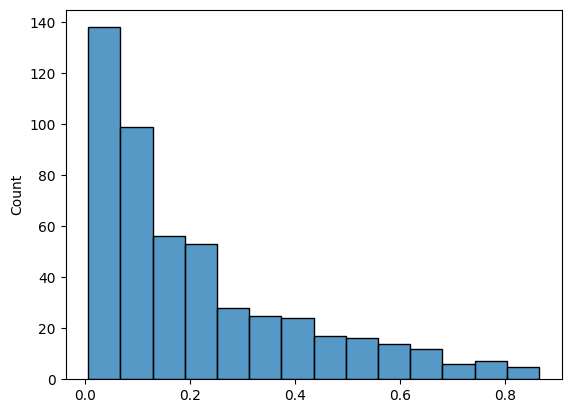

In [20]:
import seaborn as sns
sns.histplot(round_0_preds)

<Axes: ylabel='Count'>

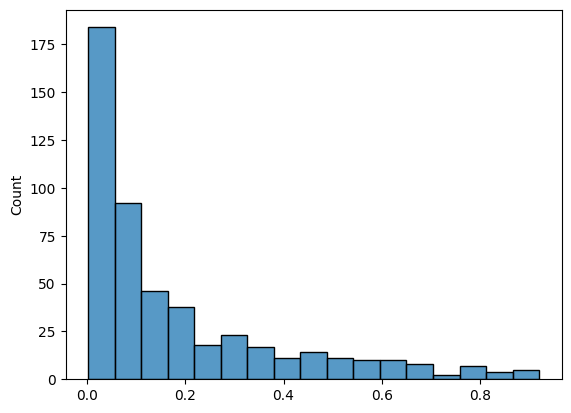

In [22]:
sns.histplot(round_4_preds)

In [23]:
round_0_preds[:10]

[0.181017205119133,
 0.09872841089963913,
 0.04060767590999603,
 0.5762943625450134,
 0.11129254847764969,
 0.041440874338150024,
 0.10570655018091202,
 0.21028733253479004,
 0.7318072319030762,
 0.3370550870895386]

In [24]:
from rich import print as rprint
rprint(all_item_responses_round_0[8])

(
    "Sarah is a young professional living in a bustling city. She loves to go for runs in the local park to clear 
her mind and stay active. One day while on her usual run, she sees her coworker Michael and her friend Emma engaged
in a heated conversation in the middle of the park. Sarah tries to avoid them, not wanting to get caught up in 
their dispute, but she can't help but overhear their argument. \n\nIt becomes clear that Michael and Emma have been
dating in secret, but Michael has just revealed to Emma that he is actually engaged to another woman named Sarah - 
a different Sarah, not the Sarah who is watching the scene unfold. Emma is understandably upset and confronts 
Michael about his deception. Michael tries to explain and plead with Emma, but Emma is furious and threatens to 
expose their affair to the other Sarah.\n\nSarah, the observer, is now in a difficult position. She has 
inadvertently become privy to sensitive information that could impact multiple people's lives. She knows the right 
thing to do would be to distance herself and let Michael and Emma resolve their own issues. However, she also feels
compelled to protect her namesake, the other Sarah who is engaged to Michael. Sarah doesn't know if she should 
intervene in the argument, contact the other Sarah, or simply walk away and pretend she saw nothing.",
    'Sarah should quietly slip away from the scene, not wanting to get involved in the argument or potentially 
escalate the situation. She should then discreetly contact the other Sarah, informing her about the situation and 
advising her to be prepared for a potentially difficult conversation with Michael. Sarah should then keep a low 
profile, avoiding any further interactions with Michael and Emma, and let them work out their issues on their own. 
This way, Sarah can maintain her distance while still being a good friend and ally to the other Sarah'
)

# Detection using set difference of NERs

In [3]:
all_item_responses_round_0 = all_item_responses_round_0[["creative_scenario_round_0","creative_response_round_0"]]
all_item_responses_round_4 = all_item_responses_round_4[["creative_scenario_round_4","creative_response_round_4"]]

In [4]:
import spacy
nlp = spacy.load("en_core_web_md")

In [45]:
all_item_responses_round_0["scenario_set"] = None
all_item_responses_round_0["response_set"] = None

In [32]:
# def apply_func(row):
#     doc1 = nlp(row["creative_scenario_round_0"])
#     doc2 = nlp(row["creative_response_round_0"])
#     doc1_ents = set()
#     doc2_ents = set()
#     for ent in doc1.ents:
#         doc1_ents.add(ent.text)
#     for ent in doc2.ents:
#         doc2_ents.add(ent.text)
    
#     row["scenario_set"] = doc1_ents
#     row["response_set"] = doc2_ents
# all_item_responses_round_0.parallel_apply(lambda x: apply_func(x), axis=1)   

In [46]:
from rich import print as rprint
from tqdm import tqdm
for index, row in tqdm(all_item_responses_round_0[:500].iterrows(), total=len(all_item_responses_round_0)):
    doc1 = nlp(row["creative_scenario_round_0"])
    doc2 = nlp(row["creative_response_round_0"])
    doc1_ents = set()
    doc2_ents = set()
    for ent in doc1.ents:
        doc1_ents.add(ent.text)
    for ent in doc2.ents:
        doc2_ents.add(ent.text)
    
    all_item_responses_round_0.at[index, "scenario_set"] = doc1_ents
    all_item_responses_round_0.at[index, "response_set"] = doc2_ents

  1%|          | 500/68130 [00:14<31:42, 35.55it/s] 


In [54]:
all_item_responses_round_0["edit distance"] = all_item_responses_round_0["response_set"] - all_item_responses_round_0["scenario_set"]

all_item_responses_round_0["edit distance"] = all_item_responses_round_0["edit distance"].apply(lambda x: len(x) if type(x) == set else None)

In [56]:
all_item_responses_round_0["edit distance"].dropna().value_counts()

edit distance
0.0    386
1.0     95
2.0     16
3.0      2
4.0      1
Name: count, dtype: int64